Model Building - Base Model

In [1]:
import pandas as pd
import joblib

import warnings

warnings.filterwarnings("ignore")

from afl_match_outcome_model.config import match_summary_file_path
from afl_match_outcome_model.data_preparation.match_summary_preprocessor import MatchSummaryPreprocessor

from afl_match_outcome_model.modelling_data_contract import ModellingDataContract
from afl_match_outcome_model.modelling.hyperparameter_tuning import (
    XGBHyperparameterTuner,
)
from afl_match_outcome_model.modelling.supermodel import SuperXGBClassifier
from afl_match_outcome_model.modelling.optuna_xgb_param_grid import OptunaXGBParamGrid

from afl_match_outcome_model.evaluation.model_evaluation import XGBClassifierEvaluator


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
RESPONSE = ModellingDataContract.RESPONSE

Load Data

In [3]:
data = pd.read_csv(match_summary_file_path)
data = data.sort_values(by = ['Date']).reset_index(drop = True)
data.head()

,Home_Team,Away_Team,Q4_Score,Margin,Total Game Score,Home Win,Venue,City,Date,Attendance,Temperature,Weather_Type,Year,Round_ID,Match_ID,Season
0,Richmond,Melbourne,14.10.94 - 13.14.92,2,186,1.0,M.C.G.,Melbourne,2000-03-08 19:40:00,41648,NaN,NaN,2000,200001,200001_Richmond_Melbourne,NaN
1,Essendon,Port Adelaide,24.12.156 - 8.14.62,94,218,1.0,Docklands,Melbourne,2000-03-09 20:15:00,43012,NaN,NaN,2000,200001,200001_Essendon_PortAdelaide,NaN
2,North Melbourne,West Coast,16.15.111 - 24.10.154,-43,265,0.0,M.C.G.,Melbourne,2000-03-10 19:40:00,20580,NaN,NaN,2000,200001,200001_NorthMelbourne_WestCoast,NaN
3,Fremantle,Geelong,16.11.107 - 19.15.129,-22,236,0.0,Subiaco,Perth,2000-03-11 20:40:00,19777,NaN,NaN,2000,200001,200001_Fremantle_Geelong,NaN
4,St Kilda,Sydney,15.10.100 - 21.8.134,-34,234,0.0,Docklands,Melbourne,2000-03-12 19:40:00,31440,NaN,NaN,2000,200001,200001_StKilda_Sydney,NaN


Preprocessing

In [4]:
match_preprocessor = MatchSummaryPreprocessor(
    categorical_features=['Venue', 'City', 'Opponent' ,'Team'],
    rolling_cols=['Team_Score', 'Opp_Score', 'Team_Goals', 'Opp_Goals'],
    rolling=[1, 3, 5, 10, 20],
    extra_features=['Home']
)
match_preprocessor.fit(data)

MatchSummaryPreprocessor(categorical_features=['Venue', 'City', 'Opponent',
                                               'Team'],
                         extra_features=['Home'], rolling=[1, 3, 5, 10, 20],
                         rolling_cols=['Team_Score', 'Opp_Score', 'Team_Goals',
                                       'Opp_Goals'])

In [5]:
X = match_preprocessor.transform(data)
X.head()

,Home,Team_Score_rolling_1,Opp_Score_rolling_1,Team_Goals_rolling_1,Opp_Goals_rolling_1,Team_Score_rolling_3,Opp_Score_rolling_3,Team_Goals_rolling_3,Opp_Goals_rolling_3,Team_Score_rolling_5,Opp_Score_rolling_5,Team_Goals_rolling_5,Opp_Goals_rolling_5,Team_Score_rolling_10,Opp_Score_rolling_10,Team_Goals_rolling_10,Opp_Goals_rolling_10,Team_Score_rolling_20,Opp_Score_rolling_20,Team_Goals_rolling_20,Opp_Goals_rolling_20,Venue_Adelaide Oval,Venue_Bellerive Oval,Venue_Blacktown,Venue_Carrara,Venue_Cazalys Stadium,Venue_Docklands,Venue_Eureka Stadium,Venue_Football Park,Venue_Gabba,Venue_Jiangwan Stadium,Venue_Kardinia Park,Venue_M.C.G.,Venue_Manuka Oval,Venue_Marrara Oval,Venue_Norwood Oval,Venue_Perth Stadium,Venue_Princes Park,Venue_Riverway Stadium,Venue_S.C.G.,Venue_Stadium Australia,Venue_Subiaco,Venue_Sydney Showground,Venue_Traeger Park,Venue_W.A.C.A.,Venue_Wellington,Venue_York Park,City_Adelaide,City_Alice Springs,City_Ballarat,City_Brisbane,City_Cairns,City_Canberra,City_Darwin,City_Geelong,City_Gold Coast,City_Hobart,City_Launceston,City_Melbourne,City_Perth,City_Shanghai,City_Sydney,City_Townsville,City_Wellington,Opponent_Adelaide,Opponent_Brisbane Lions,Opponent_Carlton,Opponent_Collingwood,Opponent_Essendon,Opponent_Fremantle,Opponent_Geelong,Opponent_Gold Coast,Opponent_Greater Western Sydney,Opponent_Hawthorn,Opponent_Melbourne,Opponent_North Melbourne,Opponent_Port Adelaide,Opponent_Richmond,Opponent_St Kilda,Opponent_Sydney,Opponent_West Coast,Opponent_Western Bulldogs,Team_Adelaide,Team_Brisbane Lions,Team_Carlton,Team_Collingwood,Team_Essendon,Team_Fremantle,Team_Geelong,Team_Gold Coast,Team_Greater Western Sydney,Team_Hawthorn,Team_Melbourne,Team_North Melbourne,Team_Port Adelaide,Team_Richmond,Team_St Kilda,Team_Sydney,Team_West Coast,Team_Western Bulldogs
0,1,109.0,83.0,16.0,12.0,144.333333,79.000000,21.666667,12.000000,137.8,72.2,20.2,10.6,131.9,75.3,19.2,11.2,131.90,80.0,19.50,11.7,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,101.0,80.0,15.0,12.0,102.333333,117.000000,15.333333,17.666667,99.0,107.8,14.8,16.2,101.4,101.7,15.2,15.1,100.95,105.9,15.05,15.5,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,1,119.0,79.0,18.0,12.0,93.666667,97.333333,13.333333,14.666667,89.4,113.8,12.8,16.8,91.2,102.1,13.2,14.8,96.65,100.6,14.20,14.6,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,0,145.0,91.0,21.0,14.0,116.000000,100.000000,17.000000,15.000000,118.4,89.0,17.4,13.4,102.8,94.3,15.0,14.0,102.50,100.6,15.15,14.9,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Fals

In [6]:
y = match_preprocessor.get_response(data)
y.shape

(8988,)

In [7]:
y.value_counts(normalize=True)

Result
1    0.501669
0    0.498331
Name: proportion, dtype: float64

Train / Test Split

In [8]:
X.shape, y.shape

((8988, 100), (8988,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2407, stratify=y
)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2407, stratify=y_train
)

In [10]:
y_train.value_counts(), y_test.value_counts(), y_cal.value_counts()

(Result
 1    2886
 0    2866
 Name: count, dtype: int64,
 Result
 1    902
 0    896
 Name: count, dtype: int64,
 Result
 1    721
 0    717
 Name: count, dtype: int64)

In [11]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True), y_cal.value_counts(normalize=True)

(Result
 1    0.501739
 0    0.498261
 Name: proportion, dtype: float64,
 Result
 1    0.501669
 0    0.498331
 Name: proportion, dtype: float64,
 Result
 1    0.501391
 0    0.498609
 Name: proportion, dtype: float64)

In [12]:
y.mean(), y_train.mean(), y_test.mean(), y_cal.mean()

(0.5016688918558078,
 0.5017385257301809,
 0.5016685205784205,
 0.5013908205841446)

Optuna Hyperparameter Tuning Class - HyperParameterTuner & XGBHyperparameterTuner

In [13]:
xgb_tuner = XGBHyperparameterTuner(
    X_train, y_train, monotonicity_constraints={}
)

In [14]:
xgb_tuner.tune_hyperparameters()

[I 2024-01-13 11:44:55,128] A new study created in memory with name: no-name-2f676d52-dbc7-4db9-a8db-32e4548bdfda
[I 2024-01-13 11:44:55,237] Trial 0 finished with value: 0.6767246840598752 and parameters: {'max_depth': 15, 'min_child_weight': 83, 'eta': 0.043533431801897525, 'gamma': 0.8611595575757593, 'lambda': 0.03365803865985776, 'alpha': 0.17929347297506526, 'subsample': 0.5438408405942299, 'colsample_bytree': 0.3970598709164232}. Best is trial 0 with value: 0.6767246840598752.
[I 2024-01-13 11:44:55,394] Trial 1 finished with value: 0.6825985937220129 and parameters: {'max_depth': 15, 'min_child_weight': 31, 'eta': 0.02201903111597209, 'gamma': 0.0022077924383225858, 'lambda': 0.026184095290188274, 'alpha': 0.008058977152731168, 'subsample': 0.8199002403468629, 'colsample_bytree': 0.33347708645020346}. Best is trial 0 with value: 0.6767246840598752.
[I 2024-01-13 11:44:55,462] Trial 2 finished with value: 0.661526457252999 and parameters: {'max_depth': 15, 'min_child_weight': 66

Number of finished trials:  100
Best trial:
  Value: 0.6291845200795312
  Params: 
    max_depth: 6
    min_child_weight: 43
    eta: 0.4241290344409698
    gamma: 0.13697086577054668
    lambda: 0.0005256441208152189
    alpha: 0.00022362901481122712
    subsample: 0.836218376913197
    colsample_bytree: 0.8246827383014197


In [15]:
params = xgb_tuner.get_best_params()
params

{'max_depth': 6,
 'min_child_weight': 43,
 'eta': 0.4241290344409698,
 'gamma': 0.13697086577054668,
 'lambda': 0.0005256441208152189,
 'alpha': 0.00022362901481122712,
 'subsample': 0.836218376913197,
 'colsample_bytree': 0.8246827383014197}

Training Model - SuperXGBClassifier class for training and predictions

In [16]:
params["objective"] = OptunaXGBParamGrid.error
params["num_rounds"] = 1000
params["early_stopping_rounds"] = 10
params["verbosity"] = 1
params["monotone_constraints"] = {}

In [17]:
super_xgb = SuperXGBClassifier(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_cal=X_cal,
    y_cal=y_cal,
    params=params,
)

In [18]:
super_xgb.fit()

[0]	validation_0-logloss:0.66201	validation_1-logloss:0.66773
[1]	validation_0-logloss:0.64707	validation_1-logloss:0.65782
[2]	validation_0-logloss:0.63808	validation_1-logloss:0.65593
[3]	validation_0-logloss:0.63240	validation_1-logloss:0.65468
[4]	validation_0-logloss:0.62782	validation_1-logloss:0.64965
[5]	validation_0-logloss:0.62462	validation_1-logloss:0.64724
[6]	validation_0-logloss:0.62168	validation_1-logloss:0.64847
[7]	validation_0-logloss:0.61957	validation_1-logloss:0.64872
[8]	validation_0-logloss:0.61761	validation_1-logloss:0.64886
[9]	validation_0-logloss:0.61419	validation_1-logloss:0.64804
[10]	validation_0-logloss:0.61178	validation_1-logloss:0.64989
[11]	validation_0-logloss:0.60623	validation_1-logloss:0.65053
[12]	validation_0-logloss:0.60402	validation_1-logloss:0.64820
[13]	validation_0-logloss:0.60122	validation_1-logloss:0.64854
[14]	validation_0-logloss:0.59919	validation_1-logloss:0.64866
[15]	validation_0-logloss:0.59621	validation_1-logloss:0.64988


In [19]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8246827383014197, device=None,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.13697086577054668,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4241290344409698,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=43, missing=nan, monotone_constraints={},
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
super_xgb.calibrate()

In [21]:
preds = super_xgb.predict(X)
train_preds = super_xgb.predict(X_train)
test_preds = super_xgb.predict(X_test)

In [22]:
probas = super_xgb.predict_proba(X)[:, 1]
train_probas = super_xgb.predict_proba(X_train)[:, 1]
test_probas = super_xgb.predict_proba(X_test)[:, 1]
cal_probas = super_xgb.predict_proba(X_cal)[:, 1]

In [23]:
cal_probas = super_xgb.predict_proba(X, calibrate=True)
train_cal_probas = super_xgb.predict_proba(X_train, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test, calibrate=True)
cal_cal_probas = super_xgb.predict_proba(X_cal, calibrate=True)

Check Average Predictions

In [24]:
y.mean(), probas.mean(), cal_probas.mean()

(0.5016688918558078, 0.5057341, 0.49813676382657057)

In [25]:
y_train.mean(), train_probas.mean(), train_cal_probas.mean()

(0.5017385257301809, 0.50438535, 0.49675255250889017)

In [26]:
y_test.mean(), test_probas.mean(), test_cal_probas.mean()

(0.5016685205784205, 0.5073482, 0.4999626242410556)

In [27]:
y_cal.mean(), cal_probas.mean(), cal_cal_probas.mean()

(0.5013908205841446, 0.49813676382657057, 0.5013906487181237)

Model Evaluation

In [28]:
training_data = pd.concat([X_train, y_train], axis=1)
training_data["xgb_preds"] = train_preds
training_data["xgb_probas"] = train_probas
training_data["xgb_cal_probas"] = train_cal_probas
training_data['baseline'] = y_train.mean()
training_data['baseline_label'] = 1

train_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=training_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

In [29]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data["xgb_preds"] = test_preds
test_data["xgb_probas"] = test_probas
test_data["xgb_cal_probas"] = test_cal_probas
test_data['baseline'] = y_train.mean()
test_data['baseline_label'] = 1

test_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="xgb_cal_probas",
    expected_label_name="xgb_preds",
    compare_name="baseline",
    compare_label_name="baseline_label"
)

baseline_xgb_evals = XGBClassifierEvaluator(
    model=super_xgb.xgb_model,
    data=test_data,
    actual_name=RESPONSE,
    expected_name="baseline",
    expected_label_name="baseline_label",
)


Model Averages

In [30]:
test_data[[RESPONSE, "xgb_probas", "xgb_cal_probas", "baseline_label", "baseline"]].describe()

,Result,xgb_probas,xgb_cal_probas,baseline_label,baseline
count,1798.000000,1798.000000,1798.000000,1798.0,1798.000000
mean,0.501669,0.507348,0.499963,1.0,0.501739
std,0.500136,0.149076,0.156250,0.0,0.000000
min,0.000000,0.128527,0.082053,1.0,0.501739
25%,0.000000,0.404303,0.395736,1.0,0.501739
50%,1.000000,0.504276,0.506153,1.0,0.501739
75%,1.000000,0.615423,0.617624,1.0,0.501739
max,1.000000,0.832900,0.806880,1.0,0.501739


Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [31]:
test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.6478
Compare Log-Loss: 	0.6931


(0.6477969838864799, 0.6477969838864799)

In [32]:
test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2282
Compare Brier Score: 	0.2500


(0.22816474919640828, 0.24999722093980067)

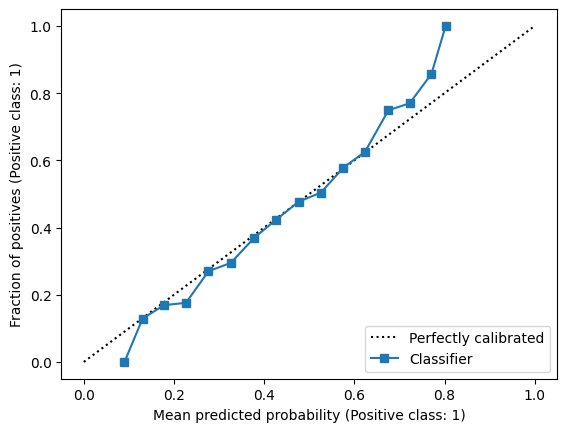

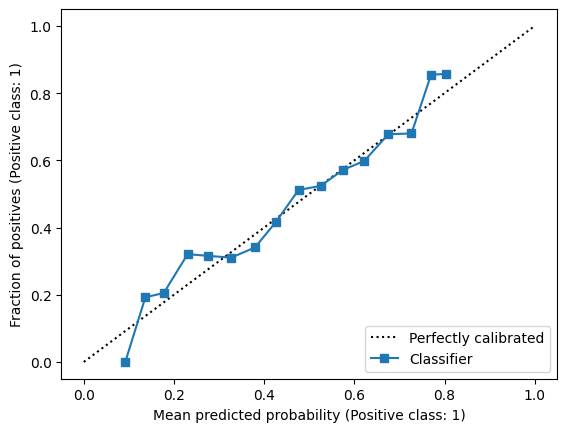

In [33]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)

In [34]:
test_xgb_evals.get_accuracy(), test_xgb_evals.get_recall(), test_xgb_evals.get_precision(), test_xgb_evals.get_f1_score()

Expected Accuracy: 	0.6201
Compare Accuracy: 	0.5017
Expected Recall: 	0.6275
Compare Recall: 	1.0000
Expected Precision: 	0.6199
Compare Precision: 	0.5017
Expected F1 Score: 	0.6237
Compare F1 Score: 	0.6681


((0.6201334816462737, 0.5016685205784205),
 (0.6274944567627494, 1.0),
 (0.619934282584885, 0.5016685205784205),
 (0.6236914600550965, 0.6681481481481483))

In [35]:
baseline_xgb_evals.get_confusion_matrix(), test_xgb_evals.get_confusion_matrix()

(array([[  0, 896],
        [  0, 902]]),
 array([[549, 347],
        [336, 566]]))

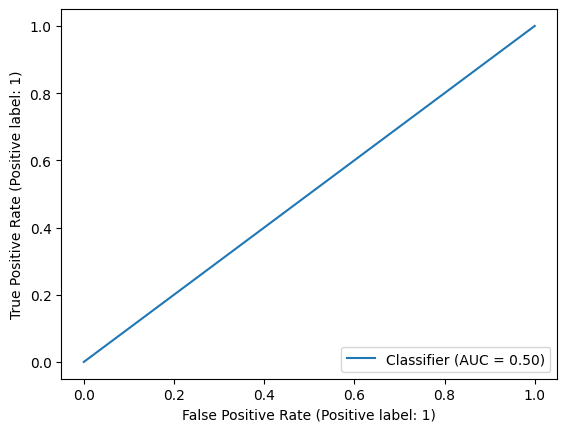

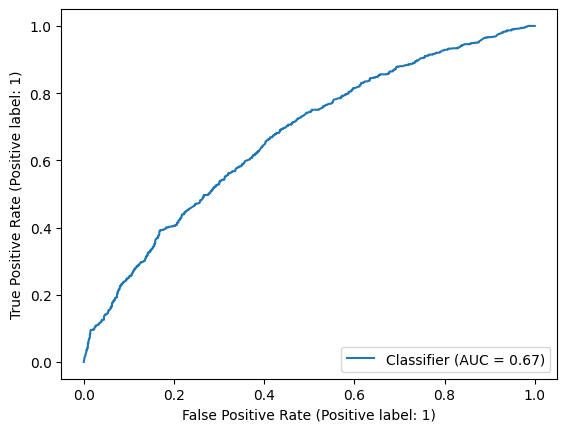

In [36]:
baseline_xgb_evals.plot_roc_curve()
test_xgb_evals.plot_roc_curve()

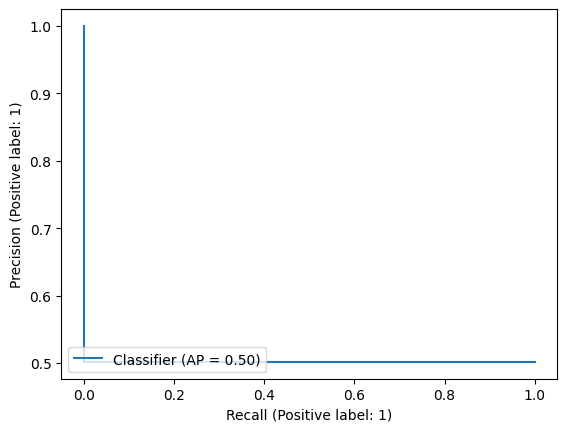

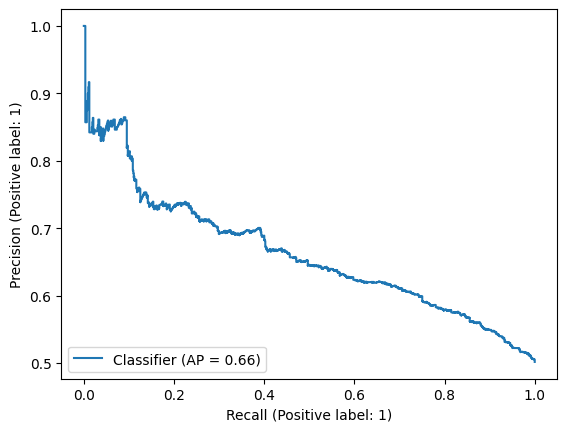

In [37]:
baseline_xgb_evals.plot_prauc_curve()
test_xgb_evals.plot_prauc_curve()

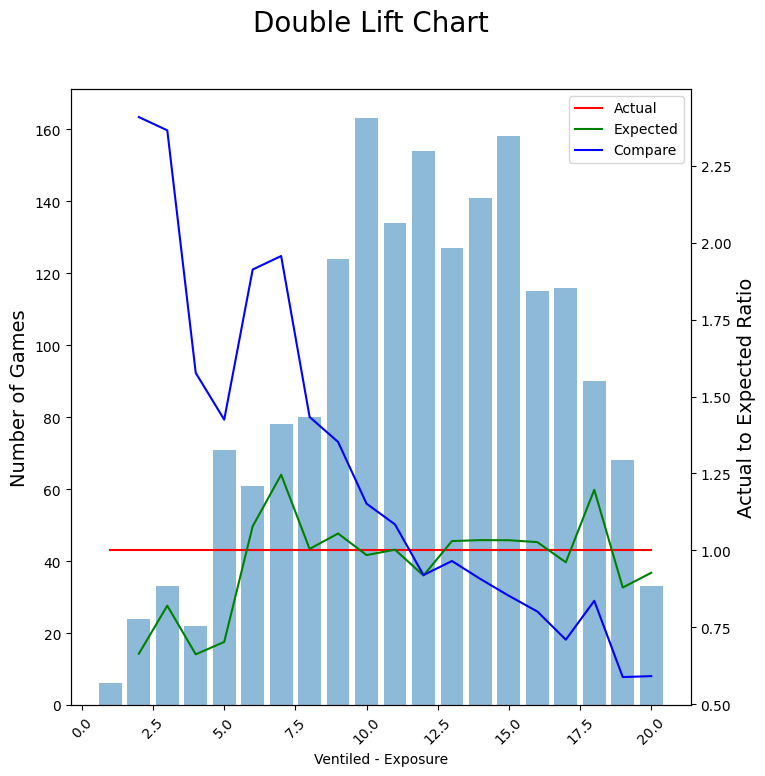

In [38]:
test_xgb_evals.plot_double_lift_chart()

Plots

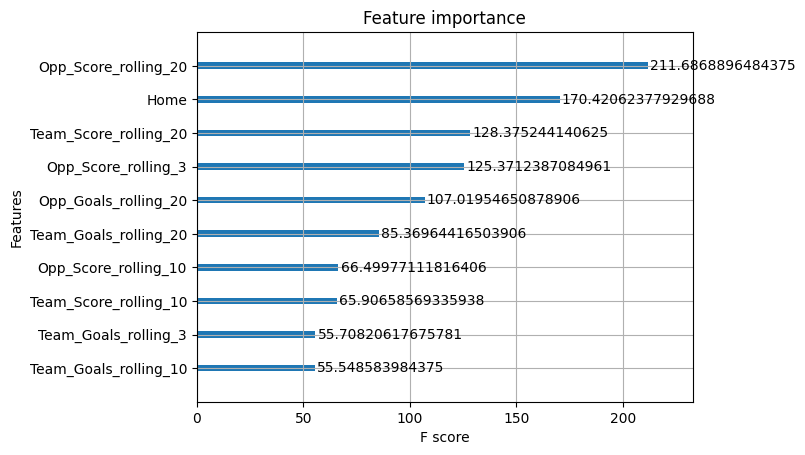

In [39]:
test_xgb_evals.plot_feature_importance(
    max_num_features=10, importance_type="total_gain"
)

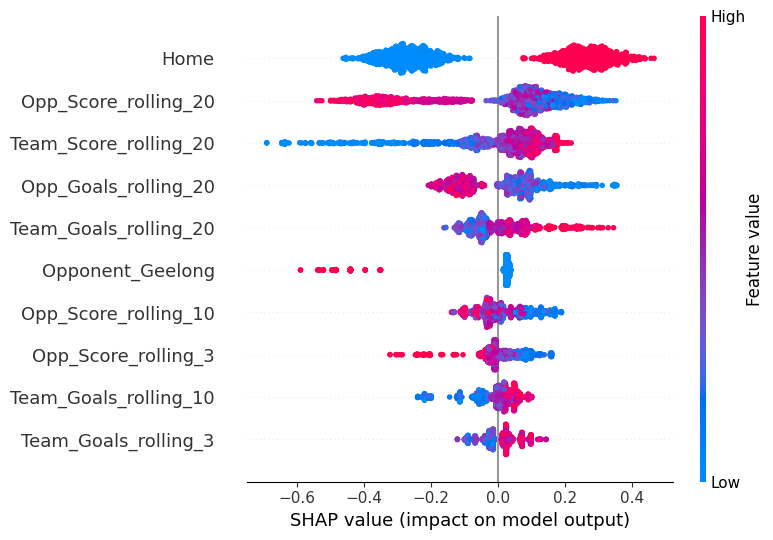

In [40]:
test_xgb_evals.plot_shap_summary_plot(sample=len(X_test))

In [41]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Home',
 'Opp_Score_rolling_20',
 'Team_Score_rolling_20',
 'Opp_Goals_rolling_20',
 'Team_Goals_rolling_20',
 'Opponent_Geelong',
 'Opp_Score_rolling_10',
 'Opp_Score_rolling_3',
 'Team_Goals_rolling_10',
 'Team_Goals_rolling_3']

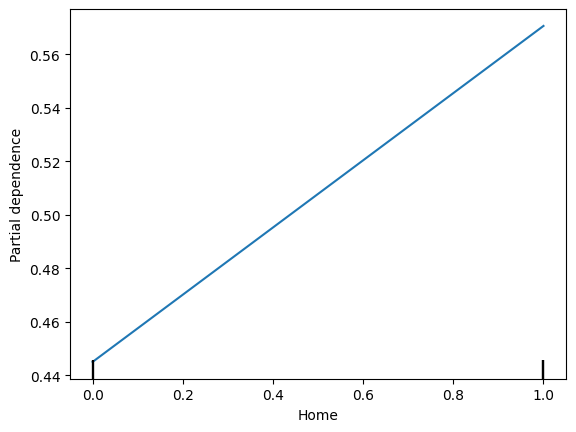

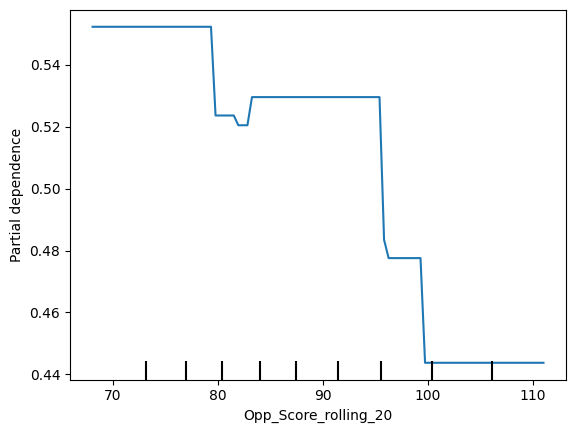

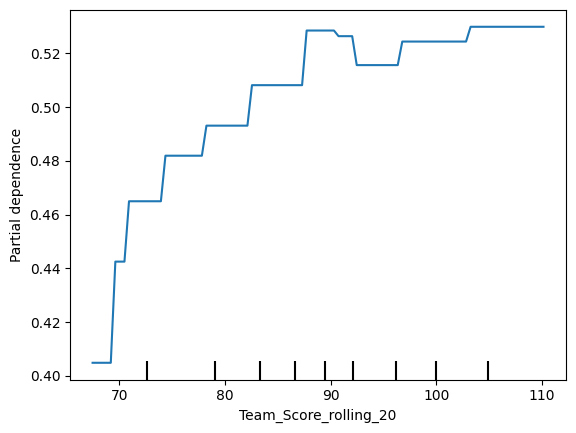

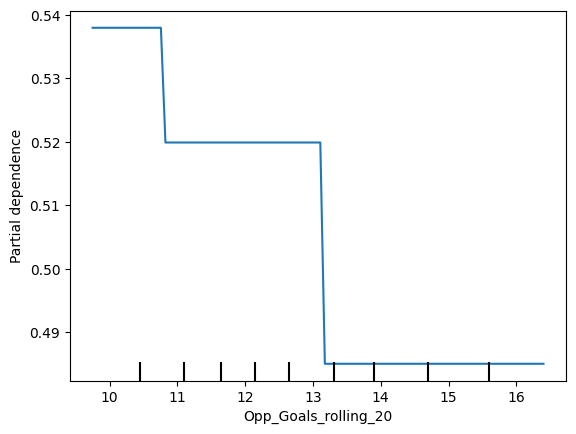

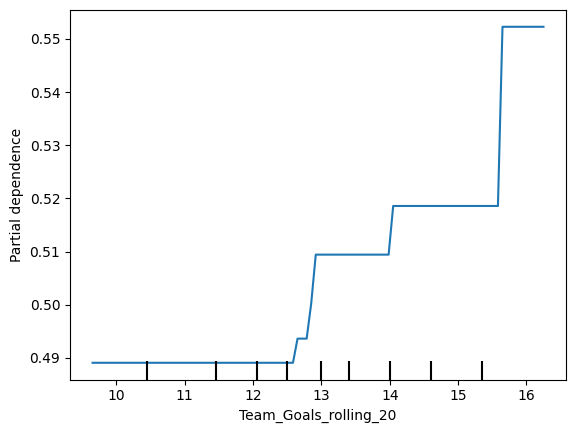

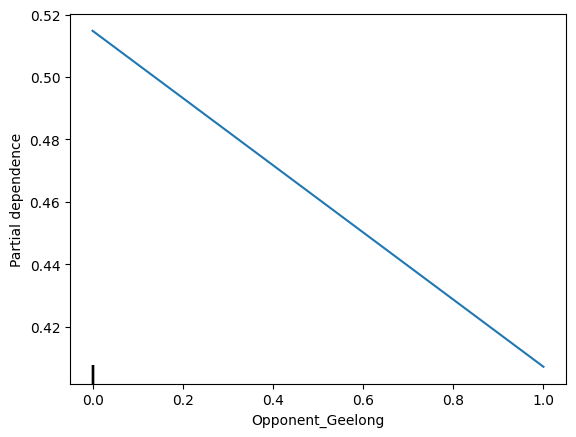

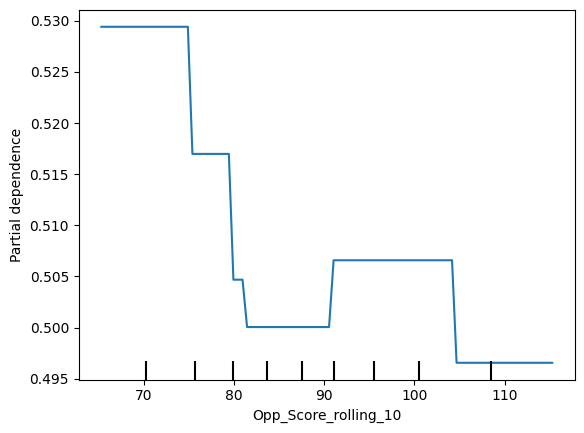

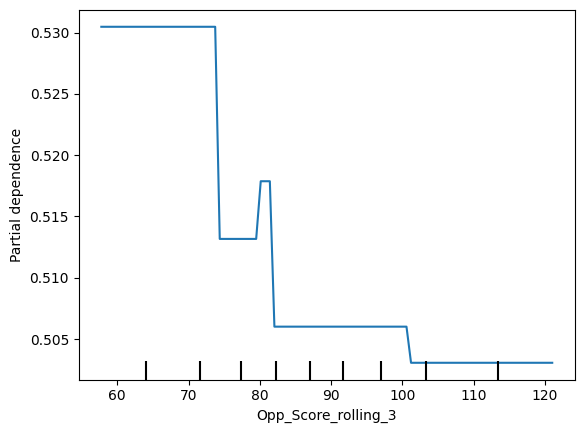

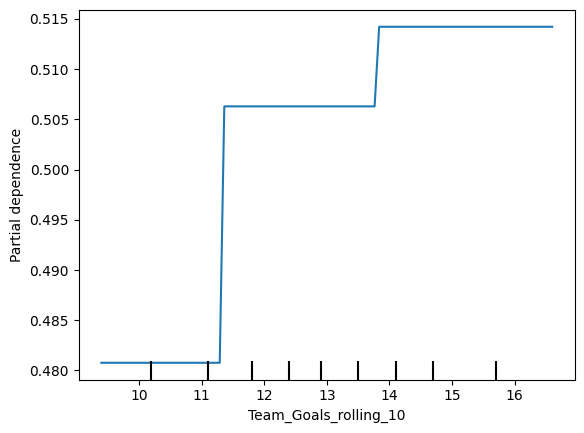

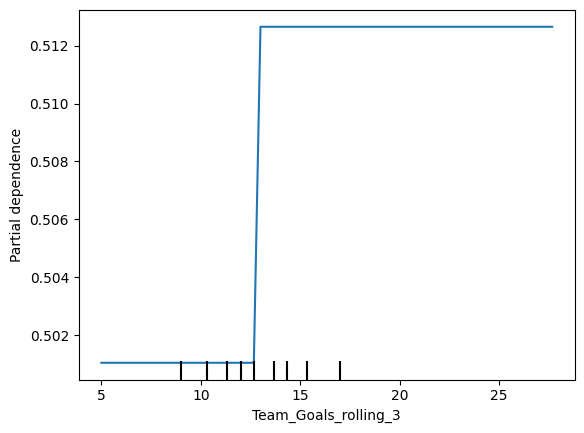

In [42]:
for col in top_10_features:
    # train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

In [43]:
# for col in top_10_features:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

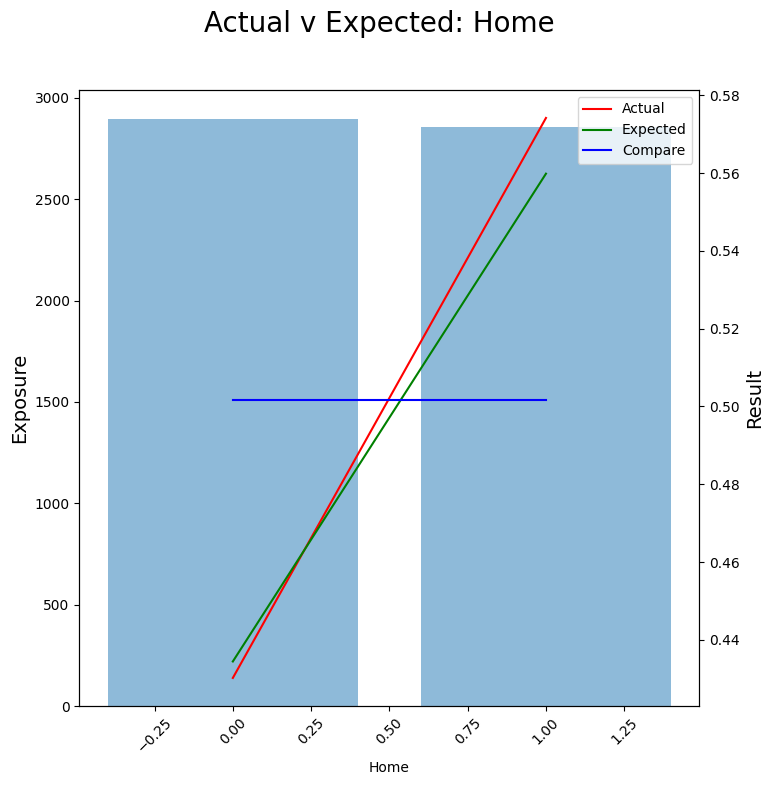

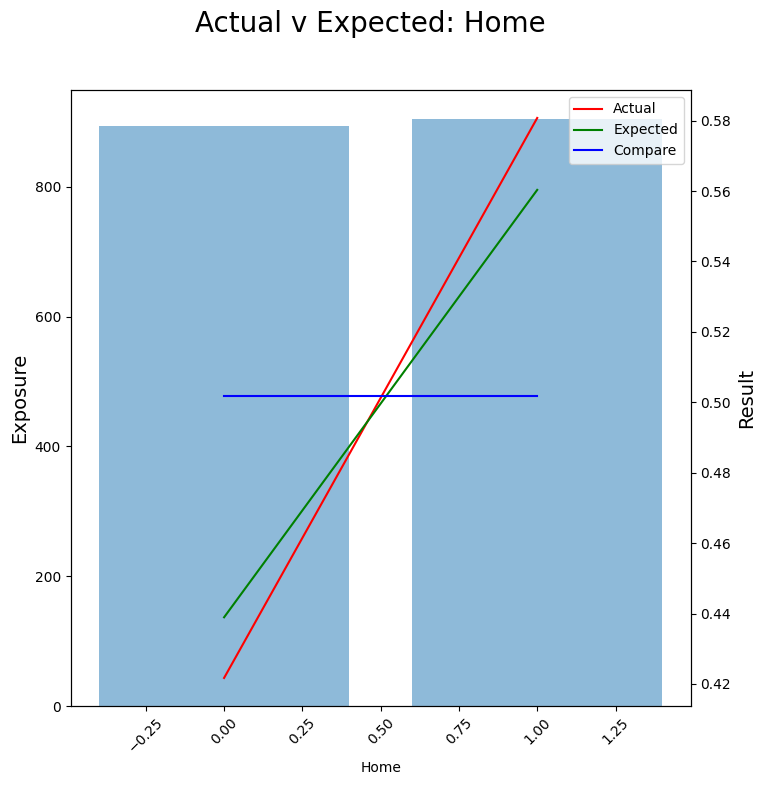

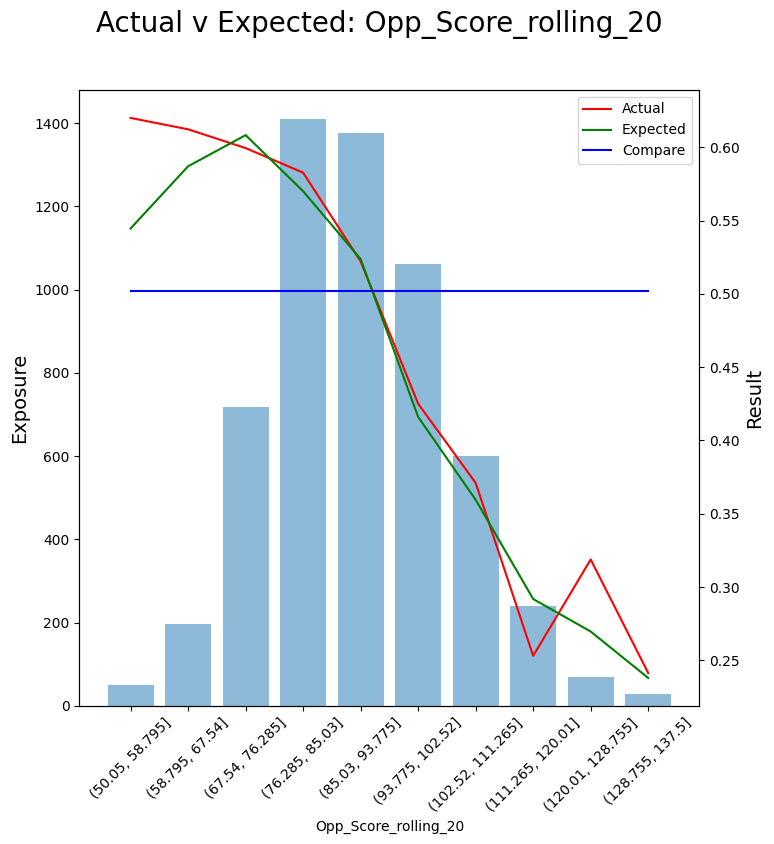

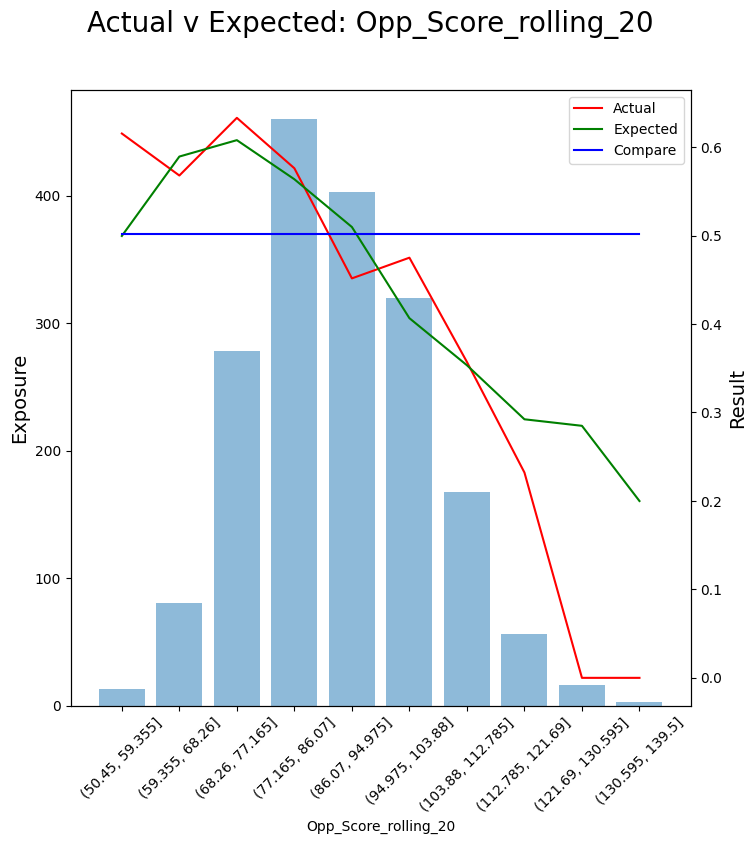

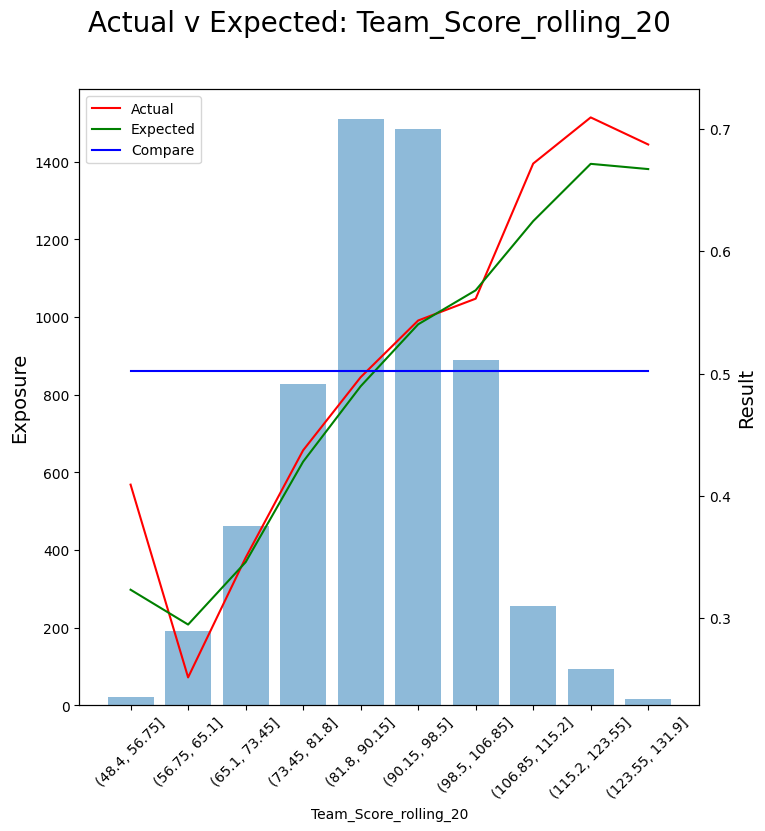

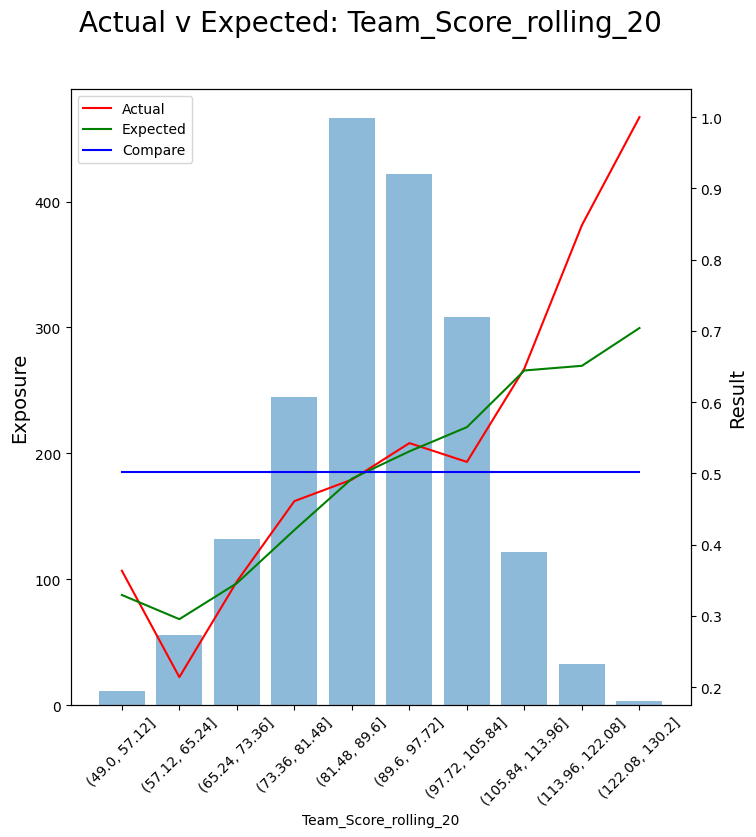

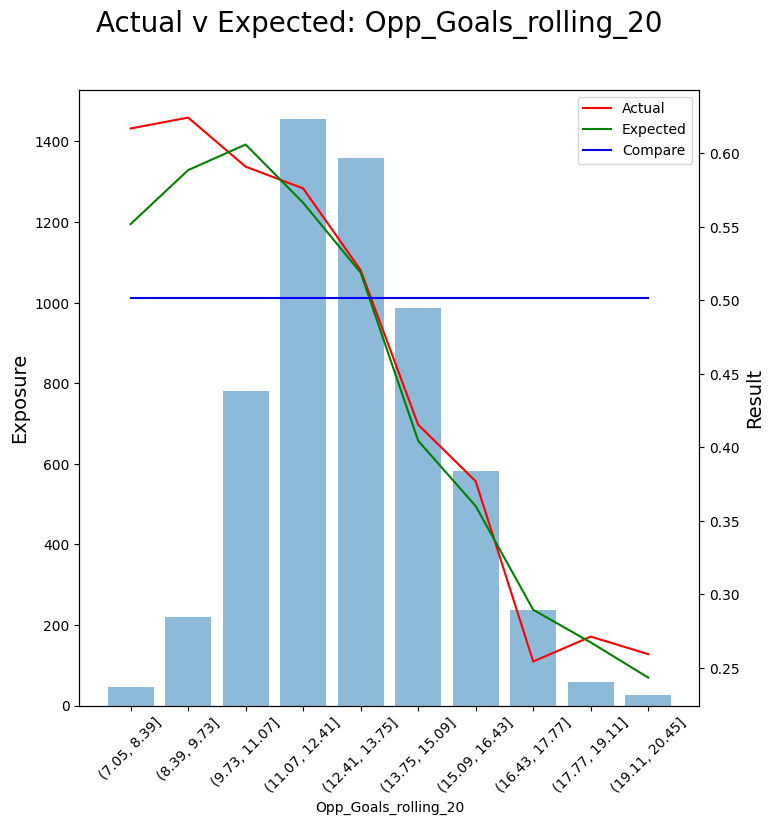

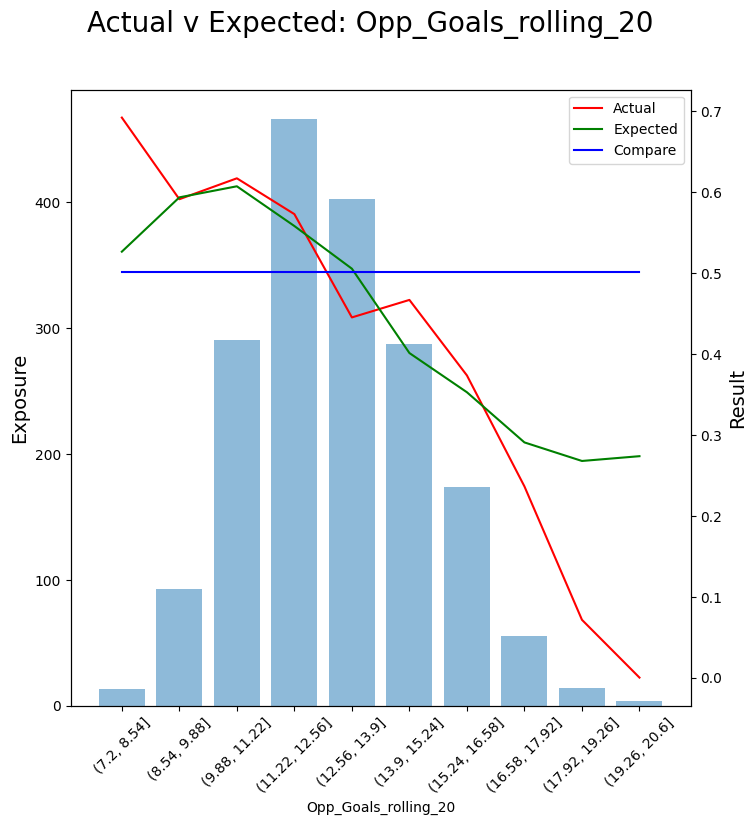

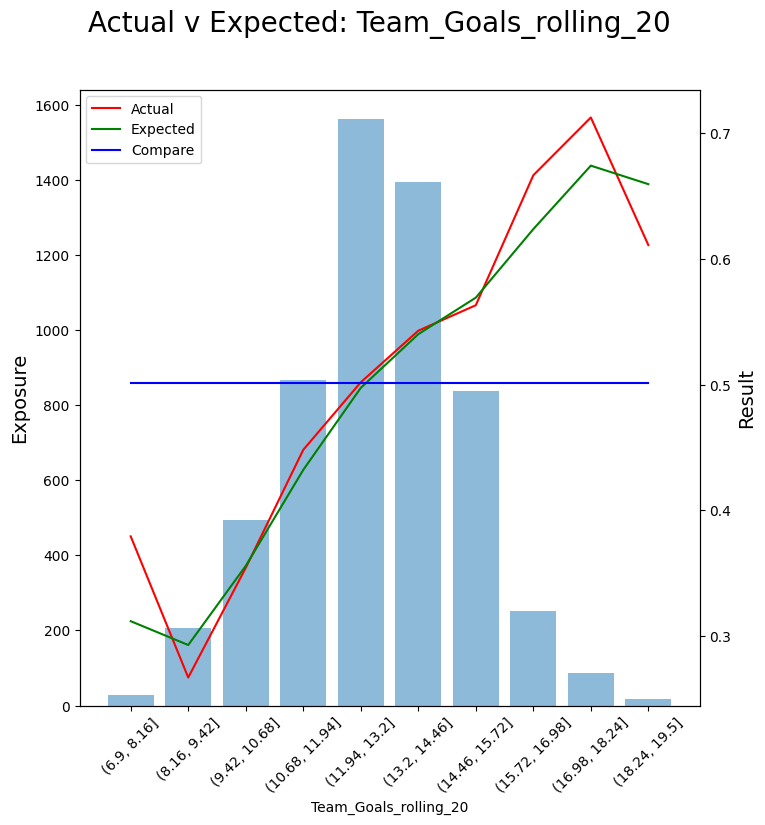

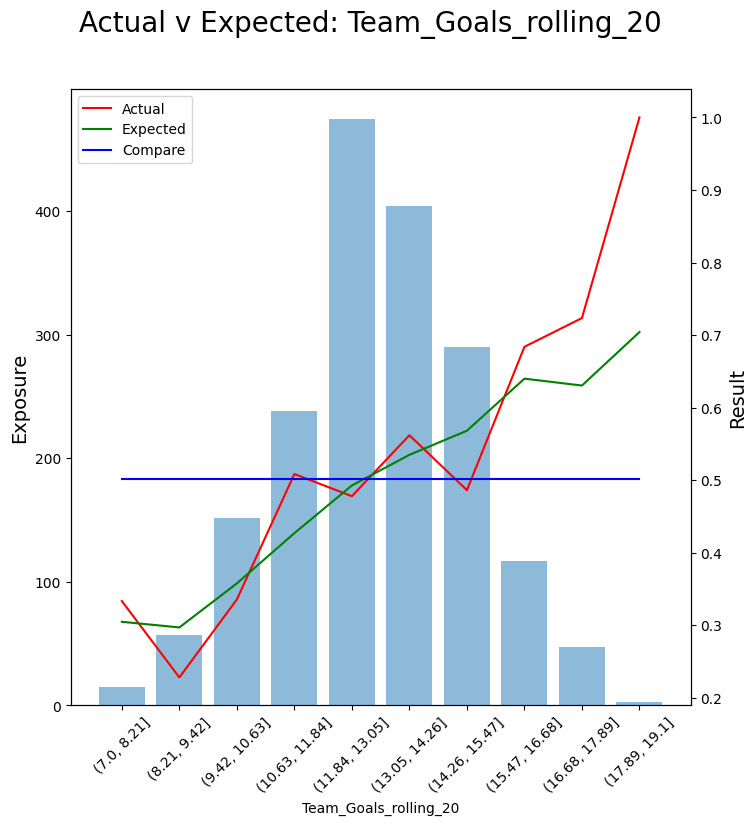

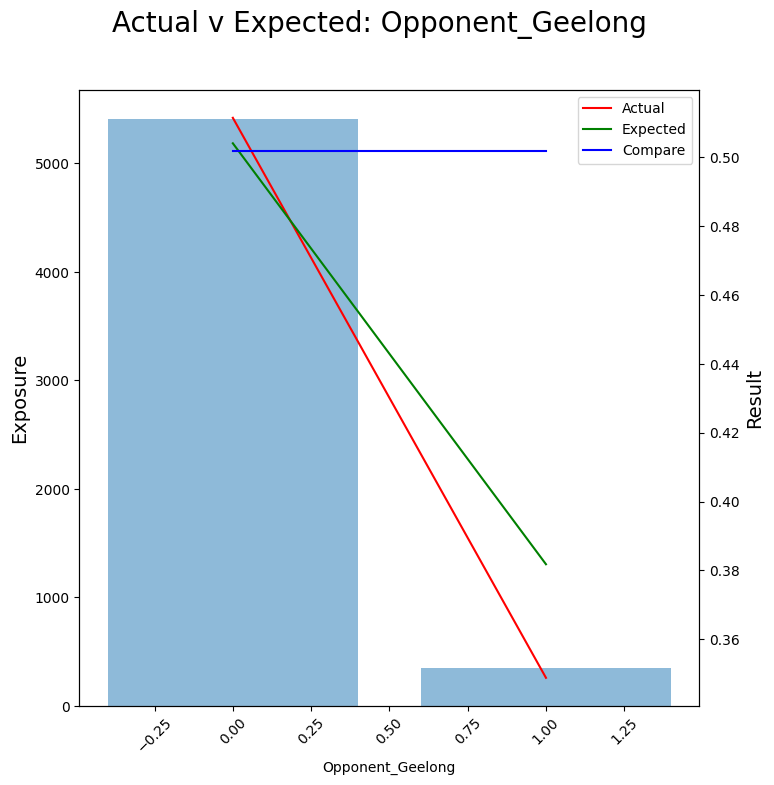

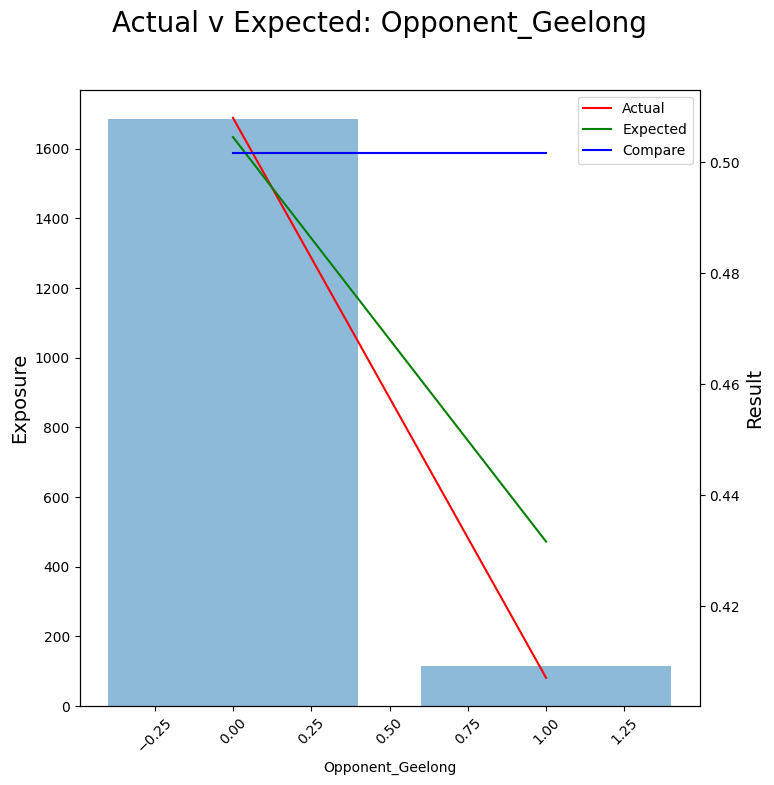

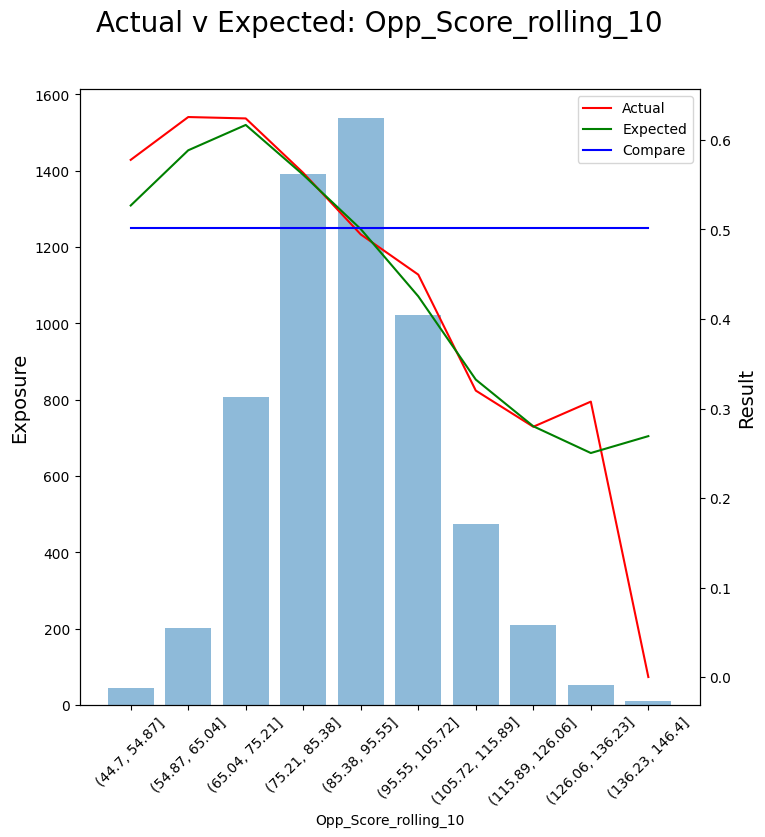

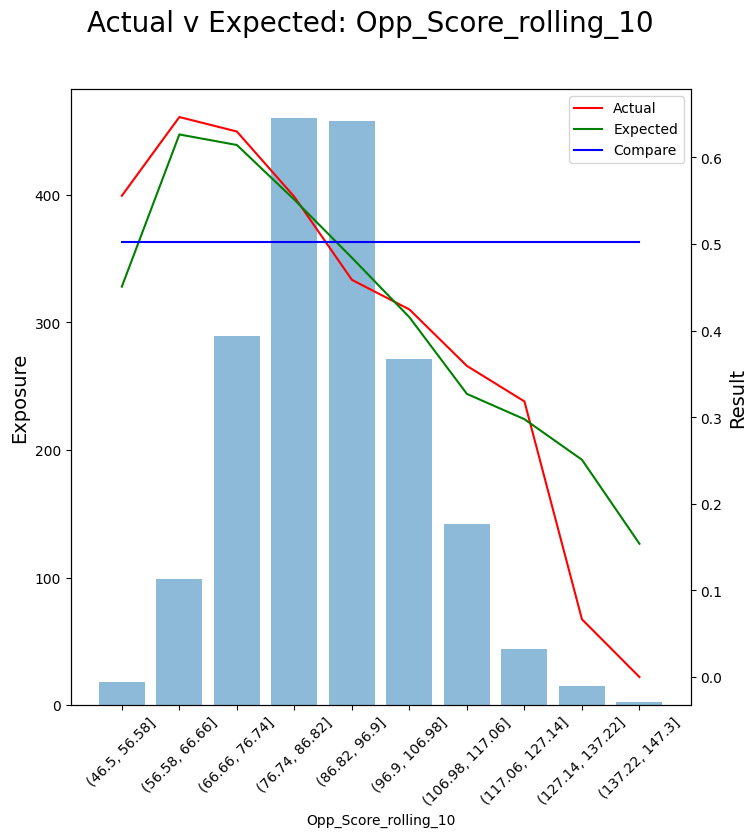

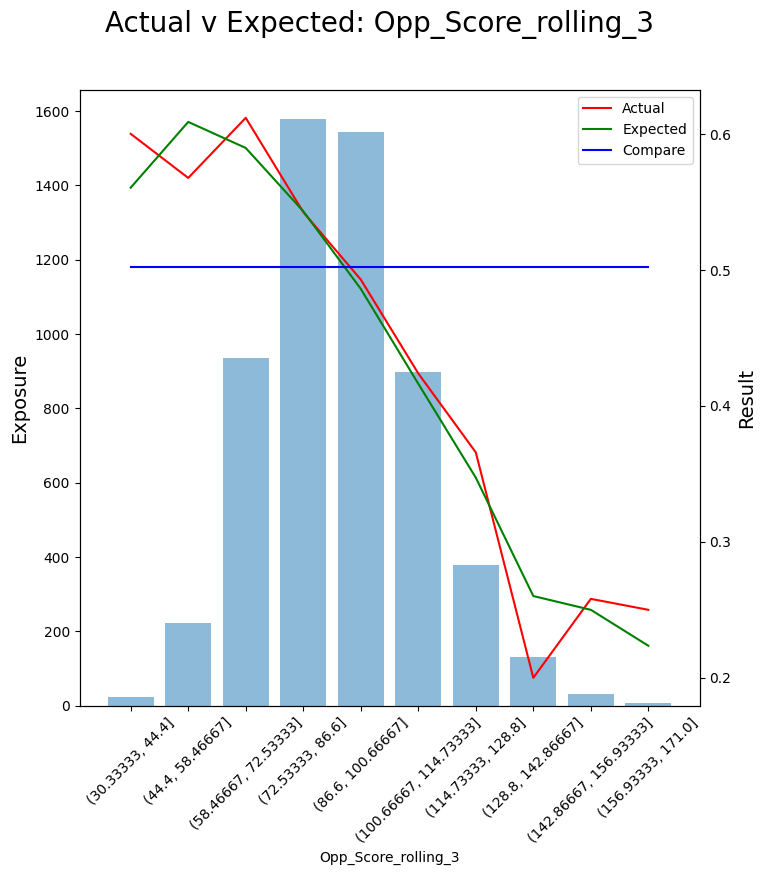

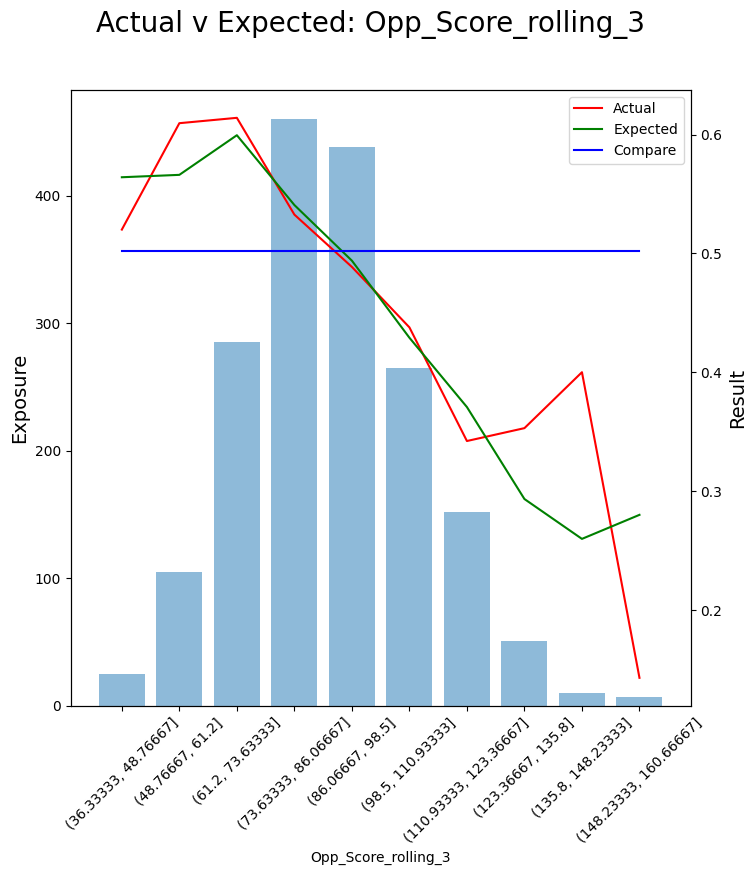

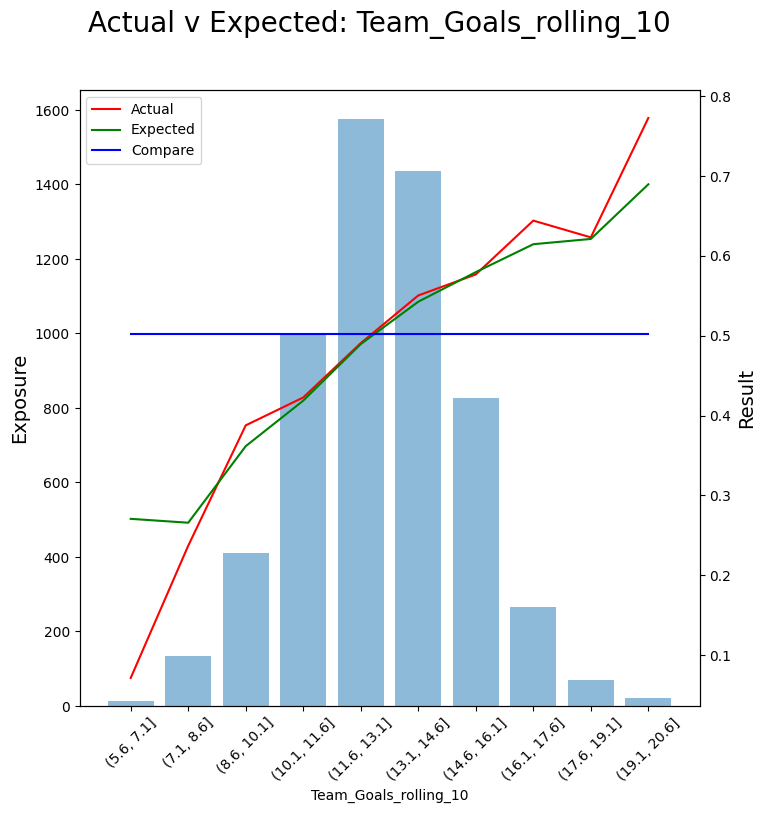

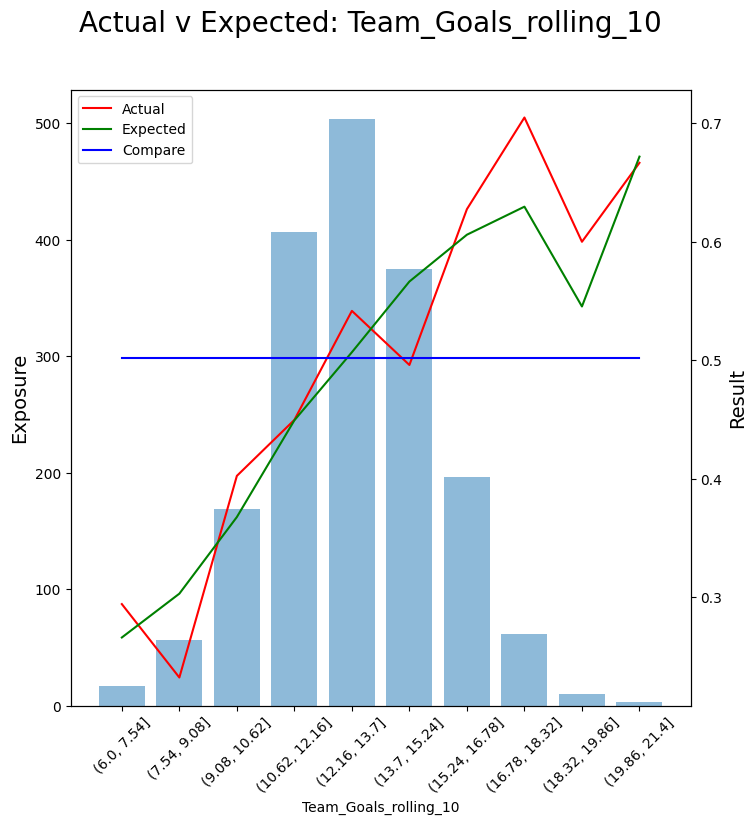

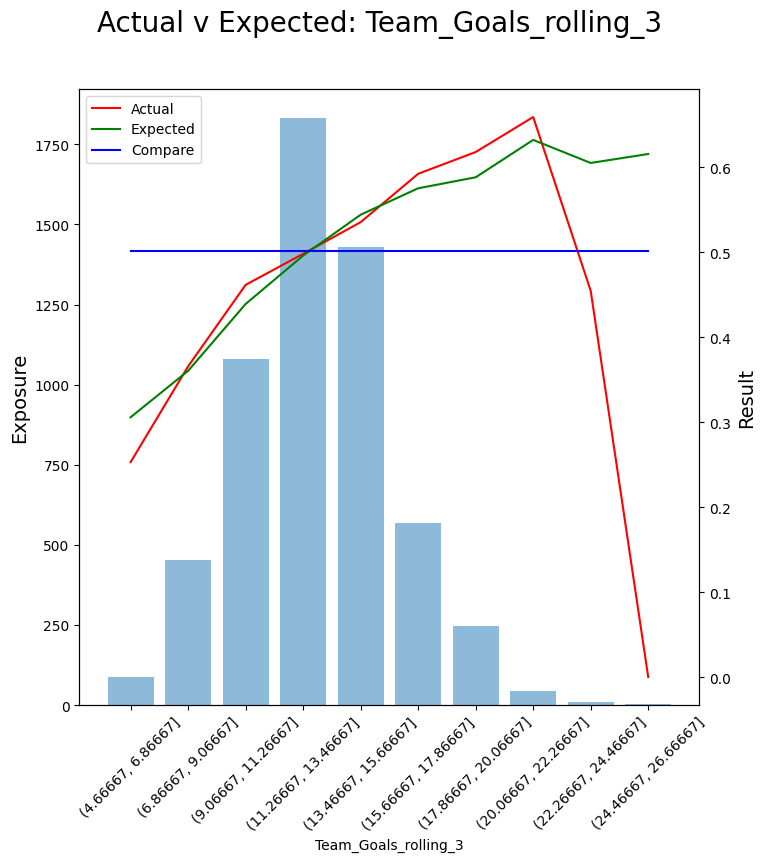

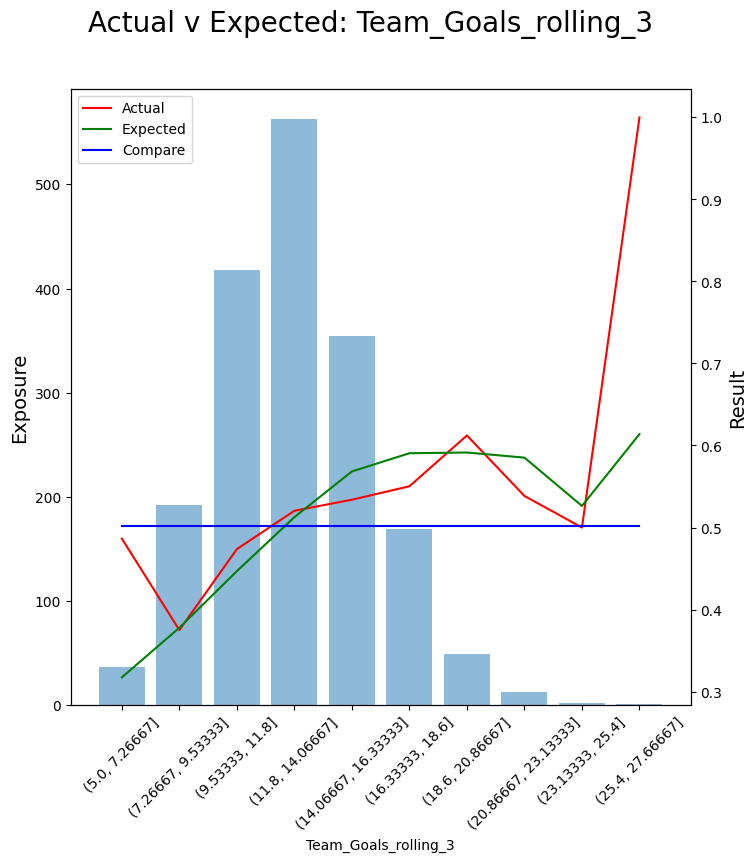

In [44]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Export and Save Pipeline

In [47]:
joblib.dump(super_xgb, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/base_match_outcome_xgb.joblib")
joblib.dump(match_preprocessor, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/base_match_outcome_match_preprocessor.joblib")

['/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/base_match_outcome_match_preprocessor.joblib']

In [45]:
pipeline = Pipeline([
    ('preprocessor', match_preprocessor),
    ('model', super_xgb)
])
pipeline.predict_proba(data, calibrate=True).mean(), pipeline.predict_proba(data, calibrate=False).mean()

(0.49813676382657057, 0.5)

In [46]:
joblib.dump(pipeline, "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/base_match_outcome_pipeline.joblib")

['/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-match-outcome-model/model_outputs/base_match_outcome_pipeline.joblib']